### About dataset :
The dataset contains three columns 'id', 'label', 'tweet' the tweet column contains all the tweets on which we have to train the model 
'label' contains the sentiment of the tweet either negative (0) or  positive (1). 

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
import numpy as np
import pandas as pd
import re
import time 

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.externals import joblib 
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle # to shuffle the data 

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import KFold, StratifiedKFold
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer



### importing the dataframe

In [3]:
data = pd.read_csv("train_tweet.csv")

### checking for null values in dataset 

In [4]:
data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

### Shuffle the data to decrease the chance of overfitting 

In [5]:
dataset = shuffle(data)

### counting the number of positive and negative tweets in the dataset 

In [6]:
dataset['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [7]:
dataset.shape

(31962, 3)

In [8]:
dataset = dataset.reset_index(drop = True)  # resetting the index

In [9]:
dataset.head()

,id,label,tweet
0,31655,0,@user we are so and we just can't hide it! ...
1,5528,1,i have been open about hvg #fibromyalgia &amp;...
2,16287,0,foods for #healing your body!! #altwaystohe...
3,16953,0,doing more of the things that makes me ! ð...
4,16405,0,unreal. knew it would only be a matter of time...


making one more column with sentiments of the tweets

In [10]:
from textblob import TextBlob
dataset['sentiment'] = dataset['tweet'].map(lambda text: TextBlob(text).sentiment.polarity)

In [11]:
dataset.head()

,id,label,tweet,sentiment
0,31655,0,@user we are so and we just can't hide it! ...,0.000000
1,5528,1,i have been open about hvg #fibromyalgia &amp;...,0.066667
2,16287,0,foods for #healing your body!! #altwaystohe...,0.781250
3,16953,0,doing more of the things that makes me ! ð...,0.625000
4,16405,0,unreal. knew it would only be a matter of time...,0.000000


### printing top positive & negative tweets 

In [12]:
print("5 random tweets with highest positive sentiment polarity: \n")
cL = dataset.loc[dataset.sentiment==1, ['tweet']].sample(5).values
for c in cL:
    print(c[0])
    print()

5 random tweets with highest positive sentiment polarity: 

let this be a great summer! #sohyped  

beautiful event on june 25th 2016 in tilburg ! 

  #monday! it's going to be a #beautiful day! make it great! #summerisnear #eyecareâ¦ 

rashford in for lallana ! england is going for a win ! i think gary neville is making decisions instead of hodgson. #engwal #euros  

according to @user @user is the best iphone app in 2016! â¡ï¸page 6â¬ï¸ ððð¼    



In [13]:
print("5 random tweets with highest nagative sentiment polarity: \n")
cL = dataset.loc[dataset.sentiment==-1, ['tweet']].sample(5).values
for c in cL:
    print(c[0])
    print()

5 random tweets with highest nagative sentiment polarity: 

ffs why?!!! omg can't believe this. so annoyed!!!!!! why would someone do this? ð¡ðð¢  #carproblems #fml #vandals   

how utterly pathetic. wish ali was around to beat this person senseless.  

show me your tits, idiot! 

the worst thing about quitting smoking is the fact i wanna eat everything.....including people's heads ð   #nicotinewithdrawal

wrestler invited a #punjabi kudi in ... -    #shocking #viral #woman #wt 



### Cleaning the dataset 

In [18]:
# Cleaning the texts
corpus = []
for i in range(0, 31962):
    tweet = re.sub('[^a-zA-Z]', ' ', dataset['tweet'][i])
    tweet = tweet.lower()
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

### saving the corpus of shuffled data

In [19]:
#save the corpus
np.save('tweet_cleaned_corpus.npy', corpus)

In [14]:
#load corpus
corpus = np.load('tweet_cleaned_corpus_shuffled.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')

### making the wordclud model of whole tweets in dataset

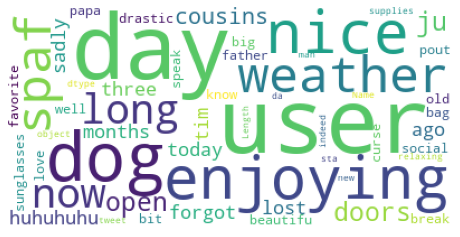

In [23]:
mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(dataset['tweet']))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### making the wordcloud model of clean corpus of shuffled dataset

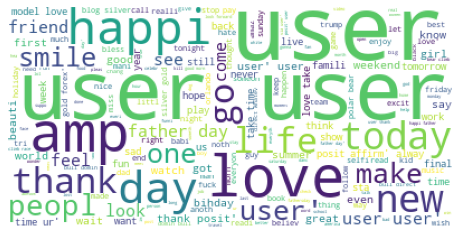

In [24]:
mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=80, 
                          random_state=42
                         ).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# TF/IDF vectorizer 

On applying tfidf the accuracy we got for different models are Naive bayes - 80.8%, LR (grid - 96%), rf - 96.4%, KNN - 94.6%, ann - 95.9%, 

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer 
# settings that you use for count vectorizer will go here

# max_df = 0.50 means "It ignores terms that appear in more than 50% of the documents".min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
# min_df = 5 means "ignore terms that appear in less than 5 documents".

tfidf_vectorizer = TfidfVectorizer(use_idf=True, stop_words = {'english'},ngram_range=(1, 2),min_df=5, max_df = 0.3)
 
# just send in all your docs here
X_tf = tfidf_vectorizer.fit_transform(corpus)
y = dataset.iloc[:, 1].values

In [24]:
X_tf.shape, y.shape

((31962, 8844), (31962,))

In [25]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tf.toarray(), y, test_size = 0.25, random_state = 0, stratify = y)

on applying normal split method the model was generating poor precision and recall for negative category, so
i appliedstratified data split technique and shuffling the data to reduce the chance of overfitting.

### Creating count vectorizer separately 

In [15]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1,3),max_features= 20000, stop_words= 'english' )
cv.fit(corpus)
X = cv.transform(corpus).toarray()
y = dataset.iloc[:, 1].values

In [16]:
# save countvectorizer model as pikel file 
joblib.dump(cv, 'cv.pkl') 

['cv.pkl']

In [12]:
# # Load the matrix from the file 
# cv = joblib.load('cv.pkl') 

In [17]:
X_cv = cv.transform(corpus).toarray()
y_cv = dataset.iloc[:, 1].values

In [18]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
Xcv_train, Xcv_test, ycv_train, ycv_test = train_test_split(X_cv, y_cv, test_size = 0.25, random_state = 0)

### Naive Bayes (93%-same)

In [19]:
# Fitting Naive Bayes to the Training set(CV)
from sklearn.naive_bayes import GaussianNB
classifier_naive = GaussianNB()
classifier_naive.fit(Xcv_train, ycv_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [20]:
# Predicting the Test set results
y_pred_cv_naive = classifier_naive.predict(Xcv_test)

In [21]:
# Predicting the Train set results
y_pred_cv_naive_train = classifier_naive.predict(Xcv_train)

In [23]:
# tfidf(stratified) + naive (test) classificaion score 
target_names = ['negative', 'positive']
print(classification_report(ycv_test, y_pred_cv_naive, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.93      0.78      0.85      7434
    positive       0.07      0.23      0.11       557

    accuracy                           0.74      7991
   macro avg       0.50      0.50      0.48      7991
weighted avg       0.87      0.74      0.80      7991



In [25]:
# tfidf(stratified) + naive (train) classificaion score 
target_names = ['negative', 'positive']
print(classification_report(ycv_train, y_pred_cv_naive_train, target_names= target_names))

              precision    recall  f1-score   support

    negative       1.00      0.80      0.89     22286
    positive       0.27      1.00      0.42      1685

    accuracy                           0.81     23971
   macro avg       0.63      0.90      0.66     23971
weighted avg       0.95      0.81      0.85     23971



In [28]:
# Fitting Naive Bayes to the Training set for Tf-idf
from sklearn.naive_bayes import GaussianNB
classifier_naive = GaussianNB()
classifier_naive.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [29]:
# Predicting the Test set results
y_pred_naive = classifier_naive.predict(X_test)

In [32]:
# tfidf(stratified) + naive (test) classificaion score 
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred_naive, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.97      0.88      0.92      7430
    positive       0.29      0.65      0.40       561

    accuracy                           0.86      7991
   macro avg       0.63      0.77      0.66      7991
weighted avg       0.92      0.86      0.89      7991



In [33]:
# Predicting the Train set results
y_pred_naive_train = classifier_naive.predict(X_train)

In [34]:
# tfidf(stratified) + naive (train) classificaion score 
target_names = ['negative', 'positive']
print(classification_report(y_train, y_pred_naive_train, target_names= target_names))

              precision    recall  f1-score   support

    negative       1.00      0.88      0.94     22290
    positive       0.39      1.00      0.56      1681

    accuracy                           0.89     23971
   macro avg       0.69      0.94      0.75     23971
weighted avg       0.96      0.89      0.91     23971



on applying naive bayes model the best accuracy we obtained is 86% which was same for tf-idf method and count
vectoriser method.

### Logistic Regression (96.4 - cv, 96.15- tfidf)

In [26]:
from sklearn.linear_model import LogisticRegression

In [36]:
X_train.shape

(23971, 8844)

applying grid search to get the optimal parameter for our model to get the best accuracy below i have applied grid
search for both count-vectorizer matrix and tf-idf matrix.

In [38]:
#Grid Search(tfidf)
from sklearn.model_selection import GridSearchCV
clf_grid_new = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc_new = GridSearchCV(clf_grid_new, param_grid = grid_values, cv = 10)
grid_clf_acc_new.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

applying grid search for stratified data to compare the result with other methods

In [39]:
y_pred_logistic_test = grid_clf_acc_new.predict(X_test)

In [40]:
y_pred_logistic_train = grid_clf_acc_new.predict(X_train)

In [41]:
# New Model Evaluation metrics for test data(Tf-Idf)
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred_logistic_test, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.97      0.99      0.98      7430
    positive       0.81      0.61      0.70       561

    accuracy                           0.96      7991
   macro avg       0.89      0.80      0.84      7991
weighted avg       0.96      0.96      0.96      7991



In [42]:
# New Model Evaluation metrics for train data(Tf-Idf)
target_names = ['negative', 'positive']
print(classification_report(y_train, y_pred_logistic_train, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.99      1.00      1.00     22290
    positive       0.99      0.93      0.96      1681

    accuracy                           0.99     23971
   macro avg       0.99      0.96      0.98     23971
weighted avg       0.99      0.99      0.99     23971



 below is the result on applying count-vectorizer

In [29]:
#Grid Search (cv)
from sklearn.model_selection import GridSearchCV
clf_grid = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc_cv = GridSearchCV(clf_grid, param_grid = grid_values, cv=10)
grid_clf_acc_cv.fit(Xcv_train, ycv_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [30]:
#Predict values for (count vectoriser)
y_pred_cv = grid_clf_acc_cv.predict(Xcv_test)

In [31]:
y_pred_train_cv = grid_clf_acc_cv.predict(Xcv_train)

In [32]:
# New Model Evaluation metrics for test data(Tf-Idf)
target_names = ['negative', 'positive']
print(classification_report(ycv_test, y_pred_cv, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.93      1.00      0.96      7434
    positive       0.00      0.00      0.00       557

    accuracy                           0.93      7991
   macro avg       0.47      0.50      0.48      7991
weighted avg       0.87      0.93      0.90      7991



In [33]:
# New Model Evaluation metrics for train data(Tf-Idf)
target_names = ['negative', 'positive']
print(classification_report(ycv_train, y_pred_train_cv, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.93      1.00      0.96     22286
    positive       0.00      0.00      0.00      1685

    accuracy                           0.93     23971
   macro avg       0.46      0.50      0.48     23971
weighted avg       0.86      0.93      0.90     23971



### random forest classifier 

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
classifier_rf = RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state= 0) 

In [48]:
# classifier_rf_cv.fit(Xcv_train, ycv_train)

In [49]:
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [50]:
y_pred_rf_test = classifier_rf.predict(X_test)

In [51]:
y_pred_rf_train = classifier_rf.predict(X_train)

In [52]:
# New Model Evaluation metrics for test data(Tf-Idf)
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred_rf_test, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.97      1.00      0.98      7430
    positive       0.89      0.54      0.68       561

    accuracy                           0.96      7991
   macro avg       0.93      0.77      0.83      7991
weighted avg       0.96      0.96      0.96      7991



In [53]:
# New Model Evaluation metrics for train data(Tf-Idf)
target_names = ['negative', 'positive']
print(classification_report(y_train, y_pred_rf_train, target_names= target_names))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     22290
    positive       1.00      0.99      1.00      1681

    accuracy                           1.00     23971
   macro avg       1.00      1.00      1.00     23971
weighted avg       1.00      1.00      1.00     23971



In [54]:
# y_pred_cv = classifier_rf_cv.predict(Xcv_test)

In [44]:
# y_pred_train_cv =  classifier_rf_cv.predict(Xcv_train)

In [45]:
# New Model Evaluation metrics for training data of countvectoriser
print('Accuracy Score : ' + str(accuracy_score(ycv_train,y_pred_train_cv)))
print('Precision Score : ' + str(precision_score(ycv_train,y_pred_train_cv)))
print('Recall Score : ' + str(recall_score(ycv_train,y_pred_train_cv)))
print('F1 Score : ' + str(f1_score(ycv_train,y_pred_train_cv)))

Accuracy Score : 0.9997496975512077
Precision Score : 1.0
Recall Score : 0.9964932787843367
F1 Score : 0.9982435597189696


In [47]:
# New Model Evaluation metrics testing countvectoriser data 
print('Accuracy Score : ' + str(accuracy_score(ycv_test,y_pred_cv)))
print('Precision Score : ' + str(precision_score(ycv_test,y_pred_cv)))
print('Recall Score : ' + str(recall_score(ycv_test,y_pred_cv)))
print('F1 Score : ' + str(f1_score(ycv_test,y_pred_cv)))

Accuracy Score : 0.961706920285321
Precision Score : 0.8504672897196262
Recall Score : 0.5141242937853108
F1 Score : 0.6408450704225352


In [111]:
# New Model Evaluation metrics training tfidf data
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.9996662634016102
Precision Score : 1.0
Recall Score : 0.6045197740112994
F1 Score : 0.4424534803583735


In [49]:
#model evaluation for testing countvectoriser data
target_names = ['negative', 'positive']
print(classification_report(ycv_test, y_pred_cv, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.97      0.99      0.98      7460
    positive       0.85      0.51      0.64       531

    accuracy                           0.96      7991
   macro avg       0.91      0.75      0.81      7991
weighted avg       0.96      0.96      0.96      7991



In [39]:
# New Model Evaluation metrics tfidf test data 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.9640845951695658
Precision Score : 0.8935483870967742
Recall Score : 0.5216572504708098
F1 Score : 0.6587395957193818


In [40]:
#model evaluation for testing tfidf data
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.97      1.00      0.98      7460
    positive       0.89      0.52      0.66       531

    accuracy                           0.96      7991
   macro avg       0.93      0.76      0.82      7991
weighted avg       0.96      0.96      0.96      7991



## fitting deep learning (tfidf + without max_feature - 95.94%)

In [28]:
import tensorflow as tf
import keras 
import time 
from keras.models import Sequential #(used to initialise the nural network)
from keras.layers import Dense #(used to create the layers in ANN)

In [29]:
print(tf.version.VERSION)

2.0.0


In [30]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds #contains tokeniser 

In [31]:
# Initialising the ANN
classifier = Sequential()

In [32]:
#adding the input and first hidden layer
classifier.add(Dense(output_dim = 2500, init = 'uniform', activation = 'relu', input_dim = 8844 ))

In [33]:
#adding second hidden layer (init is for weights)(relu is for rectifier function)
classifier.add(Dense(output_dim = 1250, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 625, init = 'uniform', activation = 'relu'))
#adding the output layer ()
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

In [34]:
#compiling the ANN
classifier.compile(optimizer= 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [35]:
y_train.shape

(23971,)

In [36]:
X_train.shape

(23971, 8844)

In [37]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2500)              22112500  
_________________________________________________________________
dense_2 (Dense)              (None, 1250)              3126250   
_________________________________________________________________
dense_3 (Dense)              (None, 625)               781875    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 626       
Total params: 26,021,251
Trainable params: 26,021,251
Non-trainable params: 0
_________________________________________________________________


In [38]:
#Fitting the ANN to the training set 
classifier.fit(X_train, y_train, batch_size = 10, nb_epoch = 5)

Epoch 1/5
23971/23971 [==============================] - 939s 39ms/step - loss: 0.2746 - accuracy: 0.9297
Epoch 2/5
23971/23971 [==============================] - 1026s 43ms/step - loss: 0.2313 - accuracy: 0.9298
Epoch 3/5
23971/23971 [==============================] - 1056s 44ms/step - loss: 0.1629 - accuracy: 0.9348
Epoch 4/5
23971/23971 [==============================] - 980s 41ms/step - loss: 0.0883 - accuracy: 0.9693
Epoch 5/5
23971/23971 [==============================] - 885s 37ms/step - loss: 0.0555 - accuracy: 0.9809


In [82]:
# #Fitting the ANN to the training set of countvectoriser  
# classifier.fit(Xcv_train, ycv_train, batch_size = 10, nb_epoch = 5)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/5
23971/23971 [==============================] - 1808s 75ms/step - loss: 0.1528 - accuracy: 0.9542
Epoch 2/5
23971/23971 [==============================] - 2145s 89ms/step - loss: 0.0404 - accuracy: 0.9867
Epoch 3/5
23971/23971 [==============================] - 2243s 94ms/step - loss: 0.0115 - accuracy: 0.9967
Epoch 4/5
23971/23971 [==============================] - 1715s 72ms/step - loss: 0.0051 - accuracy: 0.9985
Epoch 5/5
23971/23971 [==============================] - 1696s 71ms/step - loss: 0.0040 - accuracy: 0.9990


In [39]:
y_pred = classifier.predict(X_test)

In [40]:
y_train_pred = classifier.predict(X_train)

In [41]:
y_pred = (y_pred > 0.5)

In [42]:
y_train_pred = (y_train_pred > 0.5)

In [43]:
target_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names= target_names))

              precision    recall  f1-score   support

    negative       0.93      0.98      0.95      7430
    positive       0.10      0.03      0.05       561

    accuracy                           0.91      7991
   macro avg       0.51      0.50      0.50      7991
weighted avg       0.87      0.91      0.89      7991



In [83]:
y_pred_cv = classifier.predict(Xcv_test)

In [84]:
y_train_pred_cv = classifier.predict(Xcv_train)

In [37]:
y_pred_cv = (y_pred_cv > 0.5)
y_train_pred_cv =(y_train_pred_cv>.5)

In [95]:
# cv train data prediction result 
target_names = ['negative', 'positive']
print(classification_report(ycv_train, y_train_pred_cv, target_names= target_names))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     22260
    positive       1.00      0.98      0.99      1711

    accuracy                           1.00     23971
   macro avg       1.00      0.99      0.99     23971
weighted avg       1.00      1.00      1.00     23971



In [94]:
# New Model Evaluation metrics (train + cv)
print('Accuracy Score : ' + str(accuracy_score(ycv_train,y_train_pred_cv)))
print('Precision Score : ' + str(precision_score(ycv_train,y_train_pred_cv)))
print('Recall Score : ' + str(recall_score(ycv_train,y_train_pred_cv)))
print('F1 Score : ' + str(f1_score(ycv_train,y_train_pred_cv)))

Accuracy Score : 0.9985816194568436
Precision Score : 0.9952746603662138
Recall Score : 0.9848042080654588
F1 Score : 0.9900117508813161


In [88]:
# Load the model from the file(with 5000 features) 
tweet_classifier_ANN = joblib.load('tweet_classifier_ANN.pkl')  

In [89]:
y_pred = tweet_classifier_ANN.predict(X_test) # here X_test has 8844 features 

In [90]:
y_pred = (y_pred > 0.5)

In [46]:
tweet_classifier_ANN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2500)              22112500  
_________________________________________________________________
dense_2 (Dense)              (None, 1250)              3126250   
_________________________________________________________________
dense_3 (Dense)              (None, 625)               781875    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 626       
Total params: 26,021,251
Trainable params: 26,021,251
Non-trainable params: 0
_________________________________________________________________


In [91]:
# accuracy with 5000 features (95.69%)
accuracy_score(y_pred, y_test)

0.9594543861844576

### Visualising the result 

In [33]:
# initialize list of lists 
data = [['Naive', 85.97, 88.97, 89.87, 93.03], ['LogisticRegression', 96.35, 98.5, 96.39, 99.48], ['RandomForest', 96.4, 99.9, 96.1, 99.9], ['ANN', 95.94, 99.9, 95.92, 99.85]] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Model', 'Tf-idf(test)', 'Tf-idf(train)', 'cv(test)', 'cv(train)']) 

In [34]:
df

,Model,Tf-idf(test),Tf-idf(train),cv(test),cv(train)
0,Naive,85.97,88.97,89.87,93.03
1,LogisticRegression,96.35,98.50,96.39,99.48
2,RandomForest,96.40,99.90,96.10,99.90
3,ANN,95.94,99.90,95.92,99.85


In [35]:
df.iloc[:,0]

0                 Naive
1    LogisticRegression
2          RandomForest
3                   ANN
Name: Model, dtype: object

### Accuracy train and test data of models using tfidf 

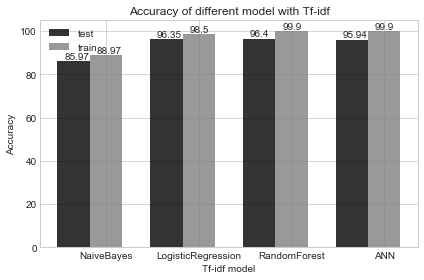

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 4
test = (85.97, 96.35, 96.4, 95.94)
train = (88.97, 98.5, 99.9, 99.9)


# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, test, bar_width,
alpha=opacity,
color='black',
label='test')

rects2 = plt.bar(index + bar_width, train, bar_width,
alpha=opacity,
color='grey',
label='train', )

plt.xlabel('Tf-idf model')
plt.ylabel('Accuracy')
plt.title('Accuracy of different model with Tf-idf')
plt.xticks(index + bar_width, ('NaiveBayes', 'LogisticRegression', 'RandomForest', 'ANN'))
plt.legend()

for index,data in enumerate(test):
    plt.text(x=index-0.1 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10))

for index,data in enumerate(train):
    plt.text(x=index+0.25 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10))
    

plt.tight_layout()
plt.show()

### Accuracy train and test data of models using CountVectorizer 

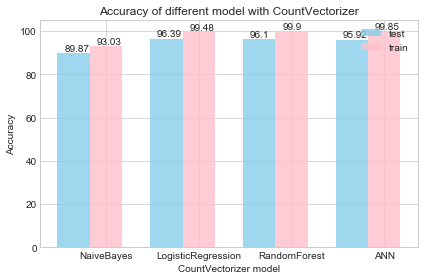

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 4
test = (89.87, 96.39, 96.1, 95.92)
train = (93.03, 99.48, 99.9, 99.85)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, test, bar_width,
alpha=opacity,
color='skyblue',
label='test')

rects2 = plt.bar(index + bar_width, train, bar_width,
alpha=opacity,
color= 'pink',
label='train')

plt.xlabel('CountVectorizer model')
plt.ylabel('Accuracy')
plt.title('Accuracy of different model with CountVectorizer')
plt.xticks(index + bar_width, ('NaiveBayes', 'LogisticRegression', 'RandomForest', 'ANN'))
plt.legend()


for index,data in enumerate(test):
    plt.text(x=index-0.1 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10))

for index,data in enumerate(train):
    plt.text(x=index+0.25 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10))
    
    
plt.tight_layout()
plt.show()

### Comparing test accuracy of tfidf and cv model

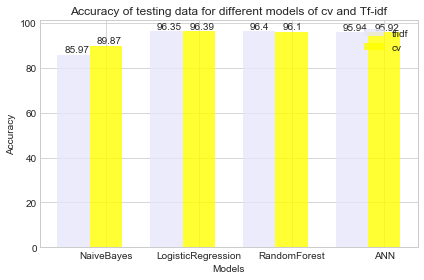

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 4
tfidf= (85.97, 96.35, 96.4, 95.94)
cv = (89.87, 96.39, 96.1, 95.92 )

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, tfidf, bar_width,
alpha=opacity,
color='lavender',
label='tfidf')

rects2 = plt.bar(index + bar_width, cv, bar_width,
alpha=opacity,
color= 'yellow',
label='cv')


plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of testing data for different models of cv and Tf-idf')
plt.xticks(index + bar_width, ('NaiveBayes', 'LogisticRegression', 'RandomForest', 'ANN'))
plt.legend()


for index,data in enumerate(tfidf):
    plt.text(x=index-0.1 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10))

for index,data in enumerate(cv):
    plt.text(x=index+0.25 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10))
    
    
plt.tight_layout()
plt.show()

#### Testing data 

In [28]:
test_dataset = pd.read_csv("test_tweet.csv")

In [29]:
test_dataset.head(3)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...


In [30]:
test_dataset.shape

(17197, 2)

In [31]:
# # Cleaning the texts
# import re
# import nltk
# #nltk.download('stopwords')
# from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer
# corpus_t = []
# for i in range(0, test_dataset.shape[0]):
#     tweet = re.sub('[^a-zA-Z]', ' ', dataset['tweet'][i])
#     tweet = tweet.lower()
#     tweet = tweet.split()
#     ps = PorterStemmer()
#     tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
#     tweet = ' '.join(tweet)
#     corpus_t.append(tweet)

In [32]:
# #save the corpus
# np.save('tweet_test_cleaned_corpus.npy', corpus_t)

In [33]:
#load the corpus
corpus_t= np.load('tweet_test_cleaned_corpus.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII')

In [34]:
X_tf_final = tfidf_vectorizer.transform(corpus_t)

In [38]:
X_tf_final.shape

(17197, 8844)

In [36]:
X_final = X_tf_final.toarray()

In [41]:
#Predict values usi lr(8844)
y_final_lr = grid_clf_acc_a.predict(X_tf_final)

In [39]:
y_final_rf = grid_clf_acc.predict(X_final)

NameError: name 'grid_clf_acc' is not defined

In [36]:
y_final

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
# Save the model as a pickle in a file(with 8844 features) 
joblib.dump(y_final, 'y_final_tweet.pkl') 

['y_final_tweet.pkl']

In [40]:
# Load the model from the file(with 8844 features) 
y_final = joblib.load('y_final_tweet.pkl')  

In [41]:
y_final.shape

(17197,)